In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('./data/data_indexes_moex_log_returns.csv', index_col=0)

In [5]:
from typing import List, Union


def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = (y_true - y_pred).abs()
    naive_average_errors = (y_true - naive_forecast).abs()

    result = average_errors.mean() / naive_average_errors.mean()
    return result


def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps
    result = (200 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result


class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

        self.y_val = None
        self.X_val = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
        '''
        if other_variables.isna().any().any():
            print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

        self.X = pd.concat([self.X, other_variables], axis=1, join='inner')

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(
            self, 
            horizon: int = 25, 
            num_recent_folds: int = None, 
            validation_part: float = None
            ) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
            validation_part (float): Процентное отношение объема исходных данных, отводимое для валидационного набора. Этот параметр особенно полезен в случаях, когда оптимизация гиперпараметров модели требует значительного времени. Рекомендуется однократно настроить гиперпараметры на валидационном наборе и применять их для последующих разбиений (фолдов), избегая повторного обучения на каждом фолде.
                В случае отсутствия значения параметра, валидационная часть данных не формируется.
        '''

        if validation_part is not None:
            if not 0 <= validation_part <= 1:
                raise ValueError("validation_part может быть только числом в отрезке от 0 до 1 включительно")
            
            last_val_obs = int(self.y.shape[0] * validation_part)

            self.y_val, self.y = self.y.iloc[:last_val_obs], self.y.iloc[last_val_obs:]
            self.X_val, self.X = self.X.iloc[:last_val_obs, :], self.X.iloc[last_val_obs:, :]

        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)

        print(f'MASE: {self.mase:.2f} (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)')
        print(f'SMAPE: {self.smape:.2f}% (на сколько % в среднем модель ошибается)')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

# Пример использования

Запихиваем ряд с доходностями в экземпляр класса

In [6]:
ts = TimeSeriesProcessor(data=data.MOEXMM)

Новый тип индексов: pd.DatetimeIndex


Добавляем лаговые переменные (какие хотим). Они автоматически появятся в ts.X

In [7]:
ts.add_lags(lags=[1, 2, 3, 4, 5, 10, 30])

Дробим на фолды (как говорил Александр Владимирович). num_recent_folds нужен для ускорения работы. Если алгоритм будет работать очень долго, можно будет просто взять только несколько последних фолдов и получить среднее предсказание по ним

In [28]:
ts.get_folds(horizon=20, num_recent_folds=10, validation_part=0.2) 

так мы можем добавть любые переменные в модель в виде pd.Dataframe. Они автоматически появятся в ts.X

In [9]:
# ts.add_other_variables(other_variables=any_data)

Обучаем модель на каждом трейне и предсказываем тест на каждом фолде. Для этого циклом проходимся по ts.folds. Он является списком кортежей, уже включающих в себя X_train, y_train, X_test, y_test. Каждый элемент списка - фолд

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

y_pred_list = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):  # tqdm чтобы визуализировать загрузку

    model.fit(X_train, y_train)

    y_pred = pd.Series(
        model.predict(X_test),
        index=X_test.index
    ) # Класс принимает только pandas форматы, а model.predict возвращает np.array. Поэтому преобразую в pd.Series

    y_pred_list.append(y_pred) 

100%|██████████| 10/10 [00:00<00:00, 121.53it/s]


Выводим совокупный результат на всех тестах всех фолдов

In [11]:
ts.get_model_result(y_pred_list) 

MASE: 0.73 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 164.82% (на сколько % в среднем модель ошибается)


Можем визуализировать работу модели

In [ ]:
# ts.get_visualisation(start_date='2022-07-01', end_date='2023-01-01')

Также в ходе работы можно посмотреть на состояние предикторов в любой момент времени

In [12]:
ts.X.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_10,lag_30
TRADEDATE,,,,,,,
2008-12-15,-0.069613,0.007149,0.010883,0.045259,0.105143,-0.088874,0.028665
2008-12-16,0.014331,-0.069613,0.007149,0.010883,0.045259,0.032821,0.102760
2008-12-17,0.027901,0.014331,-0.069613,0.007149,0.010883,0.032111,-0.004149
2008-12-18,0.036397,0.027901,0.014331,-0.069613,0.007149,0.031171,-0.111401
2008-12-19,-0.068178,0.036397,0.027901,0.014331,-0.069613,0.013328,0.019795


Те лаги и признаки, которые мы добавляем, автоматически попадают в ts.X

На таргет тоже могу посмотреть

In [13]:
ts.y.head() # На таргет тоже могу посмотреть

TRADEDATE
2008-12-15    0.014331
2008-12-16    0.027901
2008-12-17    0.036397
2008-12-18   -0.068178
2008-12-19    0.024247
Name: MOEXMM, dtype: float64

In [14]:
ts.X_val.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_10,lag_30
TRADEDATE,,,,,,,
2005-02-24,0.005027,0.011620,-0.001743,0.007954,0.005600,-0.011543,-0.013441
2005-02-25,0.039721,0.005027,0.011620,-0.001743,0.007954,0.005217,-0.005678
2005-02-28,0.004220,0.039721,0.005027,0.011620,-0.001743,-0.001106,0.027919
2005-03-01,0.044779,0.004220,0.039721,0.005027,0.011620,-0.009049,-0.000594
2005-03-02,-0.027531,0.044779,0.004220,0.039721,0.005027,0.017094,-0.017105


In [15]:
ts.y_val.head()

TRADEDATE
2005-02-24    0.039721
2005-02-25    0.004220
2005-02-28    0.044779
2005-03-01   -0.027531
2005-03-02   -0.014182
Name: MOEXMM, dtype: float64

# Catboost алгоритм

In [20]:
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna


X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
mase_scorer = make_scorer(MASE, greater_is_better=False)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'RMSE',  # Или другую функцию потерь, если нужно
        'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': 'Iter',  # Определение типа overfitting detector
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }
    
    regressor = CatBoostRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=make_scorer(MASE), 
            cv=5))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-03-15 18:57:29,840] A new study created in memory with name: no-name-22d8a535-1470-421c-ae24-57cc99296a7c
[W 2024-03-15 18:57:42,898] Trial 0 failed with parameters: {'learning_rate': 0.19425369673312126, 'depth': 8, 'l2_leaf_reg': 0.0002733839273289195, 'iterations': 229, 'min_child_samples': 87, 'border_count': 2, 'random_strength': 0.04958351108599188, 'bagging_temperature': 38.99401529033907, 'od_wait': 28} because of the following error: The value nan is not acceptable.
[W 2024-03-15 18:57:42,899] Trial 0 failed with value nan.
[I 2024-03-15 18:57:46,300] Trial 1 finished with value: 0.7439430257764686 and parameters: {'learning_rate': 0.029607429444490477, 'depth': 4, 'l2_leaf_reg': 0.00011752462201833328, 'iterations': 220, 'min_child_samples': 89, 'border_count': 196, 'random_strength': 4.185114195831041e-08, 'bagging_temperature': 0.18695857502907076, 'od_wait': 30}. Best is trial 1 with value: 0.7439430257764686.
[I 2024-03-15 18:57:51,811] Trial 2 finished with value

In [21]:
study.best_params

{'learning_rate': 0.01022314544134284,
 'depth': 4,
 'l2_leaf_reg': 2.5577143756489337e-05,
 'iterations': 243,
 'min_child_samples': 13,
 'border_count': 36,
 'random_strength': 2.3317177094480925,
 'bagging_temperature': 53.82933960019293,
 'od_wait': 39}

In [22]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                    19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
                    35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
                    51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
                    67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
                    83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
                    99],
              'y': [0.7439430257764686, 0.8151561423998765, 0.8396448616618624,
                    0.7420361222029827, 0.8195712687938611, 0.7933993468044397,
                    0.7923768618092518, 0.830174472961934, 0.8425833745696607,
                    0.7931933427600478, 0.7358084743093045, 0.7327546813089164,
                    0.7680868332159836, 0.7394947264281262, 0.8295801898439752,
                    0.7660182193767284, 0.7686176370995963, 0.8079879956217662,
                    0.784798830875132, 0.7754095037225219, 0.7989859065552519,
                    0.7329145785395076, 0.7342410252821444, 0.7990778557525928,
                    0.7432345615476528, 0.7380496589515941, 0.8010351934812648,
                    0.7888173863387771, 0.7673046888716674, 0.759234664671293,
                    0.7278713984280328, 0.7259790373442663, 0.7394713659502103,
                    0.7300917224250669, 0.7760897883907472, 0.7631341769023705,
                    0.7273111310914597, 0.846648802762077, 0.7591867675550994,
                    0.8340100528508113, 0.7875970914974652, 0.7411810845584945,
                    0.738140772806717, 0.7461157638872004, 0.7267587516063383,
                    0.7652439973753455, 0.7384891825843295, 0.8069981624470662,
                    0.8679454468064378, 0.7455270356497931, 0.7540017438817905,
                    0.7438862773996198, 0.7330508031864174, 0.7471476832678181,
                    0.7487564828059174, 0.758870293871675, 0.7969560435716792,
                    0.7643430705702956, 0.7318730682407188, 0.74128700758083,
                    0.7373421069750469, 0.7392279222060651, 0.7286539321159731,
                    0.7415281807176537, 0.7274669292576867, 0.7291646573640604,
                    0.7395433698904339, 0.7540332575201459, 0.7286972797839164,
                    0.7450871352837725, 0.7906948760428618, 0.7290109918475112,
                    0.7314997792737885, 0.7293023147210066, 0.7441635838653455,
                    0.7617908811714277, 0.7301260503868815, 0.7357182182492512,
                    0.845835783808276, 0.8640736321924459, 0.7291684607170545,
                    0.729165049220583, 0.7346409464367281, 0.729504699857428,
                    0.7515218523727489, 0.749026054405584, 0.7279500559231072,
                    0.8131249978928319, 0.7751554200643511, 0.7295929067741256,
                    0.7361918438201936, 0.7269408578215387, 0.7266631646195083,
                    0.7308741249110781, 0.732045984058767, 0.7300793285335289,
                    0.7299227460744874, 0.7278081231595496, 0.726973995121079]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [inf, 0.7439430257764686, 0.7439430257764686,
                    0.7439430257

In [33]:
optuna.visualization.plot_slice(study)

In [23]:
regressor = CatBoostRegressor(**study.best_params)

for X_train, y_train, X_test, y_test in tqdm(ts.folds):

    regressor.fit(X_train, y_train, verbose=0)

    y_pred = pd.Series(
        regressor.predict(X_test),
        index=X_test.index
    )

    y_pred_list.append(y_pred) 

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


In [24]:
ts.get_model_result(y_pred_list) 

MASE: 0.72 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 167.34% (на сколько % в среднем модель ошибается)


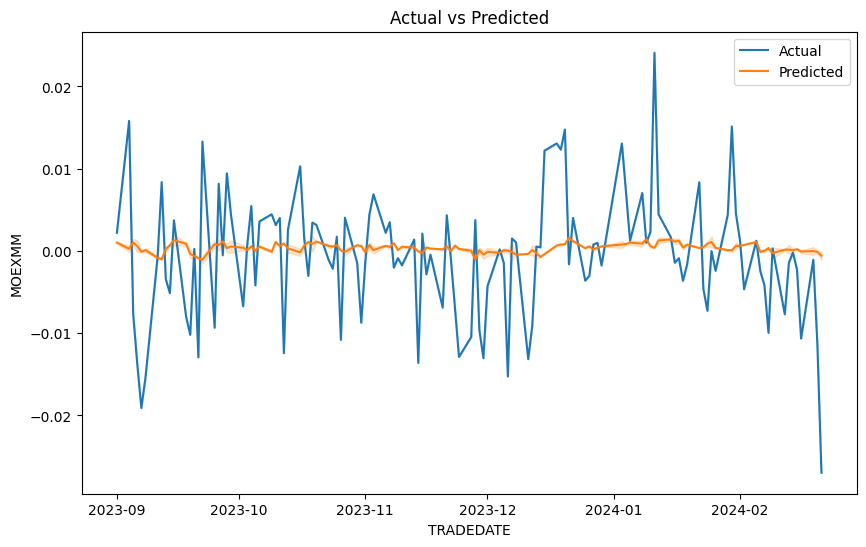

In [25]:
ts.get_visualisation(start_date='2023-09-01')

# Тестирование различных моделей

### Случайный лес

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Модель случайного леса
rf_model = RandomForestRegressor()

y_pred_list_rf = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    rf_model.fit(X_train, y_train)
    y_pred_rf = pd.Series(rf_model.predict(X_test), index=X_test.index)
    y_pred_list_rf.append(y_pred_rf) 

100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


In [50]:
ts.get_model_result(y_pred_list_rf) 

MASE: 0.78 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 158.72% (на сколько % в среднем модель ошибается)


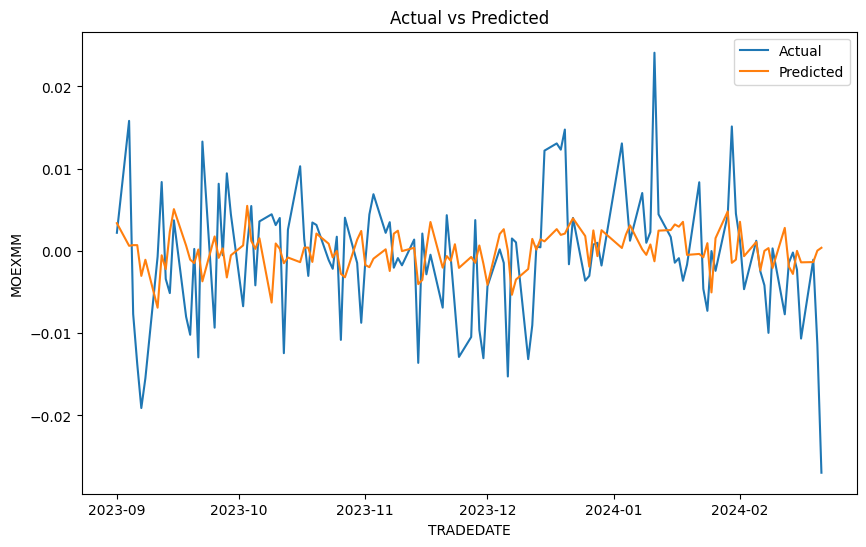

In [51]:
ts.get_visualisation(start_date='2023-09-01')

### Градиентный бустинг

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# Модель градиентного бустинга
gb_model = GradientBoostingRegressor()

y_pred_list_gb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    gb_model.fit(X_train, y_train)
    y_pred_gb = pd.Series(gb_model.predict(X_test), index=X_test.index)
    y_pred_list_gb.append(y_pred_gb)

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [53]:
ts.get_model_result(y_pred_list_gb) 

MASE: 0.74 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 164.42% (на сколько % в среднем модель ошибается)


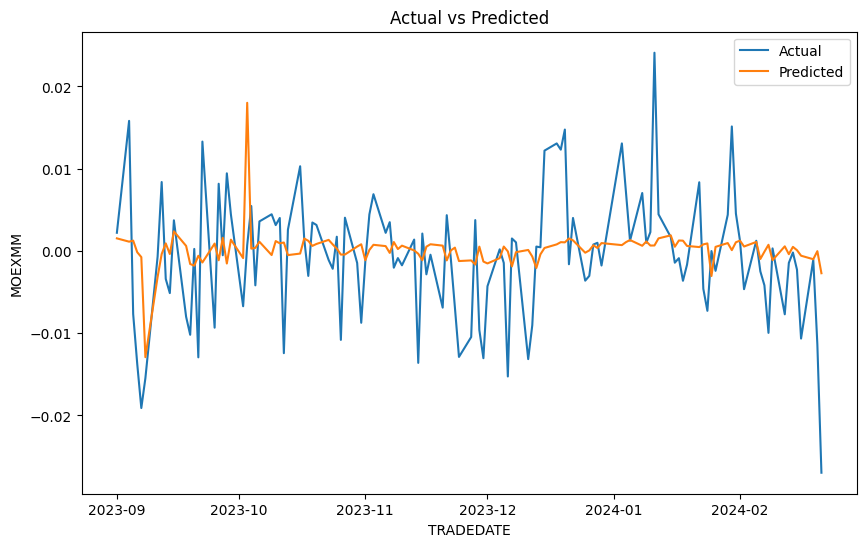

In [54]:
ts.get_visualisation(start_date='2023-09-01')

### SVR модель

In [55]:
from sklearn.svm import SVR

svr_model = SVR()

y_pred_list_svr = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    svr_model.fit(X_train, y_train)
    y_pred_svr = pd.Series(svr_model.predict(X_test), index=X_test.index)
    y_pred_list_svr.append(y_pred_svr)

100%|██████████| 10/10 [00:00<00:00, 153.84it/s]


In [56]:
ts.get_model_result(y_pred_list_svr) 

MASE: 3.85 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 172.99% (на сколько % в среднем модель ошибается)


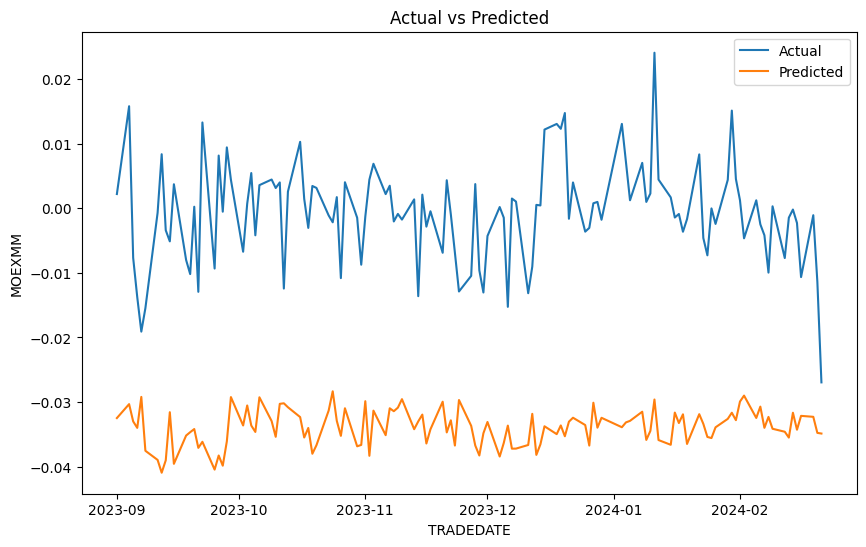

In [57]:
ts.get_visualisation(start_date='2023-09-01')

### Адаптивный бустинг

In [58]:
from sklearn.ensemble import AdaBoostRegressor

adaboost_model = AdaBoostRegressor()

y_pred_list_adaboost = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    adaboost_model.fit(X_train, y_train)
    y_pred_adaboost = pd.Series(adaboost_model.predict(X_test), index=X_test.index)
    y_pred_list_adaboost.append(y_pred_adaboost)

100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


In [59]:
ts.get_model_result(y_pred_list_adaboost) 

MASE: 0.79 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 164.52% (на сколько % в среднем модель ошибается)


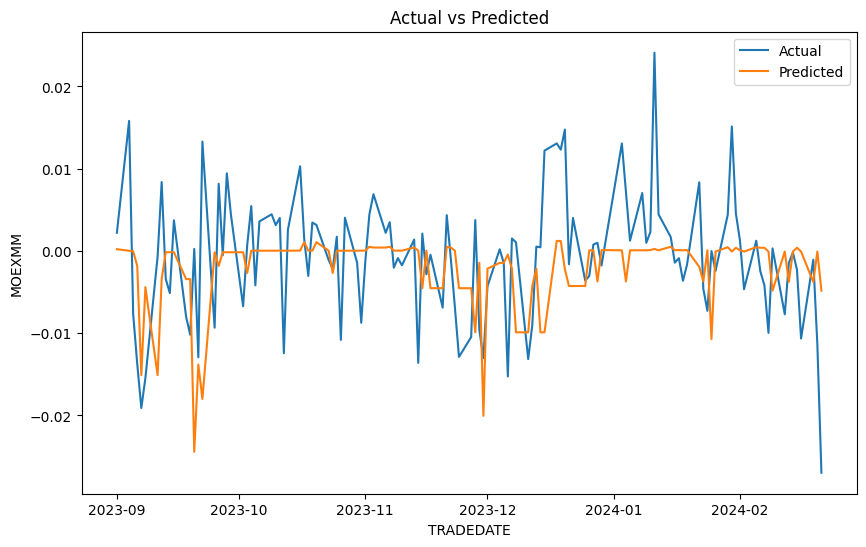

In [60]:
ts.get_visualisation(start_date='2023-09-01')

### Lasso-регрессия

In [64]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

y_pred_list_lasso = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    lasso_model.fit(X_train, y_train)
    y_pred_lasso = pd.Series(lasso_model.predict(X_test), index=X_test.index)
    y_pred_list_lasso.append(y_pred_lasso)

100%|██████████| 10/10 [00:00<00:00, 232.19it/s]


In [65]:
ts.get_model_result(y_pred_list_lasso) 

MASE: 0.73 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 178.81% (на сколько % в среднем модель ошибается)


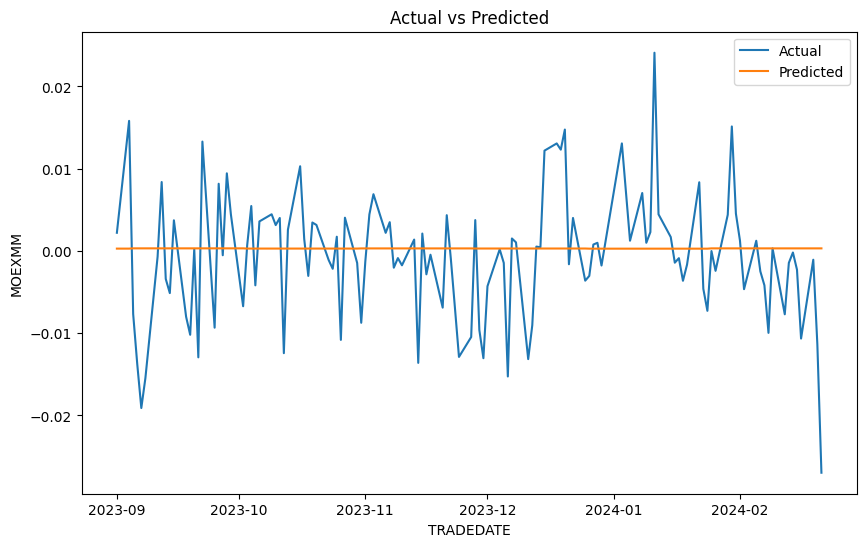

In [66]:
ts.get_visualisation(start_date='2023-09-01')

### Ridge-регрессия

In [67]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

y_pred_list_ridge = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = pd.Series(ridge_model.predict(X_test), index=X_test.index)
    y_pred_list_ridge.append(y_pred_ridge)

100%|██████████| 10/10 [00:00<00:00, 294.31it/s]


In [68]:
ts.get_model_result(y_pred_list_ridge) 

MASE: 0.73 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 176.17% (на сколько % в среднем модель ошибается)


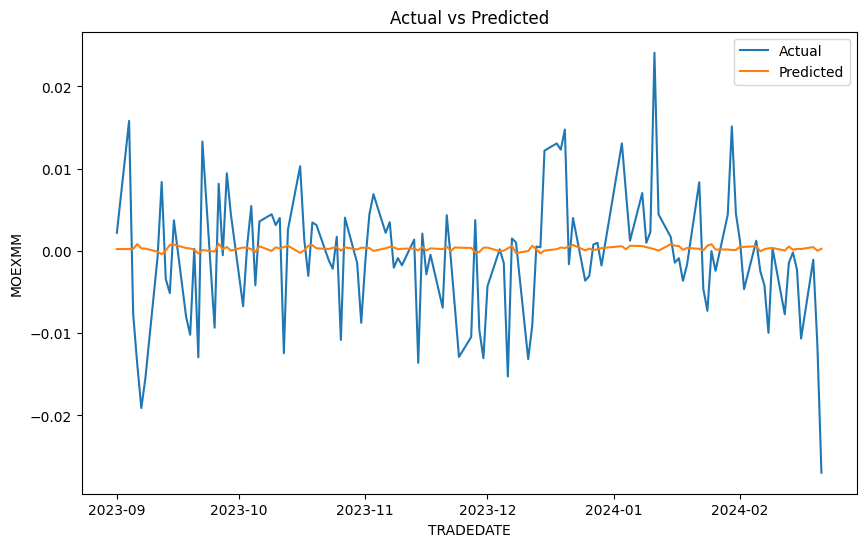

In [69]:
ts.get_visualisation(start_date='2023-09-01')

### К-ближайших соседей 

In [70]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()

y_pred_list_knn = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    knn_model.fit(X_train, y_train)
    y_pred_knn = pd.Series(knn_model.predict(X_test), index=X_test.index)
    y_pred_list_knn.append(y_pred_knn)

100%|██████████| 10/10 [00:00<00:00, 123.64it/s]


In [72]:
ts.get_model_result(y_pred_list_knn) 

MASE: 0.86 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 148.69% (на сколько % в среднем модель ошибается)


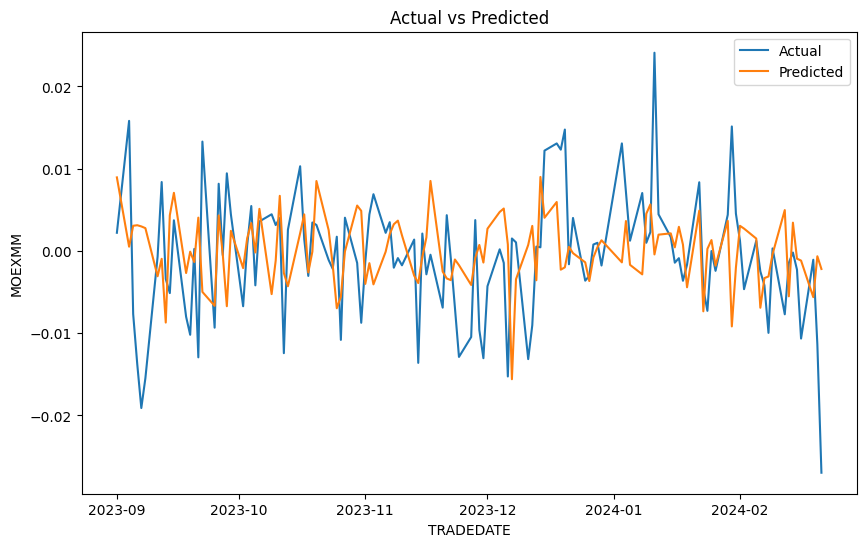

In [73]:
ts.get_visualisation(start_date='2023-09-01')

### Xgboosting

In [143]:
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
mase_scorer = make_scorer(MASE, greater_is_better=False)

def objective(trial):
    
    param = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Скорость обучения
    'max_depth': trial.suggest_int('max_depth', 3, 100),  # Максимальная глубина деревьев
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),  # Минимальное снижение значения функции потерь, чтобы сделать разделение
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),  # L1 регуляризация
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),  # L2 регуляризация
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Доля наблюдений, используемая для обучения каждого дерева
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Доля признаков, используемая для обучения каждого дерева
    'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),  # Минимальный вес дочерних узлов
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Количество деревьев
    'objective': 'reg:squarederror'  # Функция потерь
    }
    
    regressor = xgb.XGBRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=make_scorer(MASE), 
            cv=5))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-03-15 20:33:18,809] A new study created in memory with name: no-name-aca7fcec-d8d2-44ee-a25d-75e2ee55e14c


[I 2024-03-15 20:33:22,884] Trial 0 finished with value: 0.708304153017125 and parameters: {'learning_rate': 0.20415258954157148, 'max_depth': 17, 'gamma': 0.32596903042756753, 'reg_alpha': 3.0911154749063946e-08, 'reg_lambda': 0.36585507513160337, 'subsample': 0.8339598001849482, 'colsample_bytree': 0.7419636629716909, 'min_child_weight': 9.121024564802582, 'n_estimators': 403}. Best is trial 0 with value: 0.708304153017125.
[I 2024-03-15 20:33:25,527] Trial 1 finished with value: 0.7090625134991823 and parameters: {'learning_rate': 0.22735676206476965, 'max_depth': 25, 'gamma': 0.1531256120037615, 'reg_alpha': 1.1984664640899947e-06, 'reg_lambda': 1.293642289401412e-07, 'subsample': 0.9588612253189188, 'colsample_bytree': 0.6783185916165383, 'min_child_weight': 6.800257238383789, 'n_estimators': 995}. Best is trial 0 with value: 0.708304153017125.
[I 2024-03-15 20:33:25,691] Trial 2 finished with value: 0.7083095888287888 and parameters: {'learning_rate': 0.23214671883025179, 'max_de

In [144]:
study.best_params

{'learning_rate': 0.25735480203468497,
 'max_depth': 12,
 'gamma': 0.5834482417222959,
 'reg_alpha': 6.009104058938608e-07,
 'reg_lambda': 10.091355517383313,
 'subsample': 0.5235784654040991,
 'colsample_bytree': 0.9173275030831198,
 'min_child_weight': 7.639412222135795,
 'n_estimators': 378}

In [150]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.708304153017125, 0.7090625134991823, 0.7083095888287888,
                    0.7088136419575768, 0.708918194262685, 0.708918194262685,
                    0.708918194262685, 0.7076336409496714, 0.7091470440181034,
                    0.7088662351025279, 0.7080706877487275, 0.7083052315163864,
                    0.7108661794642985, 0.7091597449447506, 0.7084980979629174,
                    0.7092300264841216, 0.7084188651342322, 0.7087251408459196,
                    0.7088039159337362, 0.7087331895664101, 0.7090337919892603,
                    0.7082910021332063, 0.7093702863736411, 0.7090508671853243,
                    0.709422275087227, 0.7092513839536598, 0.7085084094846641,
                    0.7086834438631323, 0.7095136177217463, 0.7093809769193693,
                    0.708874866528239, 0.7078718180802204, 0.7079920803446194,
                    0.7092849768551822, 0.7088225534397912, 0.7087065159031258,
                    0.731349808094143, 0.7085488719443951, 0.7091214204404125,
                    0.708918194262685, 0.7089857707400319, 0.7086897735040415,
                    0.7089340105597984, 0.708981673214502, 0.7084432425379192,
                    0.7089151546022855, 0.7083352099506621, 0.708918194262685,
                    0.7085407386379263, 0.709482245227285, 0.709337874265238,
                    0.7093125240415749, 0.7088423496389995, 0.708279248690286,
                    0.7082934020948036, 0.7082497395694759, 0.7084460252832916,
                    0.7073988637317985, 0.7081030222491138, 0.7087065171501628,
                    0.7083225025494604, 0.7088468245091578, 0.7083837674120536,
                    0.7076364315541385, 0.7085145425993975, 0.7081664378085379,
                    0.7111531122005645, 0.7097489273021527, 0.7097285959235669,
                    0.7093053406505356, 0.7108263345853713, 0.7091729973609909,
                    0.7105273678913555, 0.7092226675084582, 0.7095162168820562,
                    0.7082195903642919, 0.7088776958922212, 0.7087928731365094,
                    0.7084270273995346, 0.7092995260396161, 0.7085366655185977,
                    0.7093064594502999, 0.7078200330389978, 0.7102863262254857,
                    0.7087872615668334, 0.7097922553322743, 0.7087558384719894,
                    0.7100352947700068, 0.7080001293549291, 0.7089961621235625,
                    0.7086571183582319, 0.7095592425965451, 0.7090501151176853,
                    0.7085097705503915, 0.7081354209254545, 0.7088227787744182,
                    0.708672193669868, 0.7082170095575537, 0.7091597817412355,
                    0.7085837538980245]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.708304153017125, 0.7083041530171

In [135]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                   50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                                   62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
                                   74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
                                   86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                                   98, 99],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.5975766447440338, 0.7386442969543032, 0.8996595777267612,
                    0.5807391638548505, 0.7865999169871805, 0.5559528230970134,
                    0.5071890893471944, 0.5652153877743604, 0.964638394158355,
                    0.6810218606118981, 0.8256528018777978, 0.8441728104923307,
                    0.8416039240694618, 0.7634783508079036, 0.7800681159490501,
                    0.6885025733123006, 0.6640439220323348, 0.6525177383813432,
                    0.6447996806492978, 0.7306617792943916, 0.9201780349194557,
                    0.688146350184346, 0.7045562623942174, 0.6283270903323405,
                    0.8054995300442994, 0.7164677186285041, 0.7727454563350549,
                    0.6602145335673244, 0.6184652625786269, 0.8721040837208575,
                    0.525137504771112, 0.7922454924205613, 0.7982474486923122,
                    0.7323781615581653, 0.7539199486266075, 0.6070083016700999,
                    0.6847188491377573, 0.8824287853145196, 0.7982055701276931,
                    0.9902479699851252, 0.6999098159451426, 0.8281148462022484,
                    0.823985516164913, 0.9268814565198578, 0.7447116855854257,
                    0.580957880305538, 0.5818954222490761, 0.5852081767369856,
                    0.5507650781670146, 0.6616447965176961, 0.5476643764689201,
                    0.7897534205512181, 0.8663734874421011, 0.8429368108869827,
                    0.7688601308922458, 0.6370003463025836, 0.6365555889730621,
                    0.6697501914711553, 0.6717781881873116, 0.7104279333457413,
                    0.5048846840421914, 0.6092088569402976, 0.6150021755910172,
                    0.6008069861551896, 0.5761152421990732, 0.531194436530581,
                    0.7242815054685239, 0.6518835945089837, 0.6244403044149842,
                    0.6867118148373672, 0.6714049762643524, 0.6357227233065833,
                    0.6008185660315205, 0.5685623188048634, 0.6981434701461138,
                    0.6929611234716031, 0.73853188235056, 0.7501947281410082,
                    0.7164431565097792, 0.6650370092138101, 0.8129776198950905,
                    0.6500047960452116, 0.6396662119097588, 0.6193551412085552,
                    0.7015915305400459, 0.5886358462351109, 0.7615621060175123,
                    0.6773690591567264, 0.6092046062277312, 0.7869

In [136]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(**study.best_params)

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


In [137]:
ts.get_model_result(y_pred_list_xgb) 

MASE: 0.73 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 177.51% (на сколько % в среднем модель ошибается)


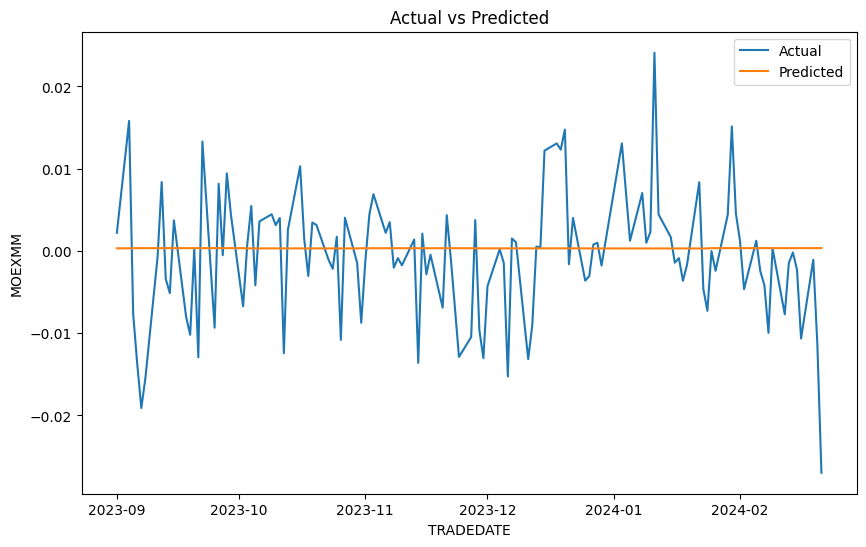

In [138]:
ts.get_visualisation(start_date='2023-09-01')

In [139]:
#Без поиска параметров работает лучше почему-то..
xgb_model = xgb.XGBRegressor()

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


In [140]:
ts.get_model_result(y_pred_list_xgb) 

MASE: 0.87 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 152.48% (на сколько % в среднем модель ошибается)


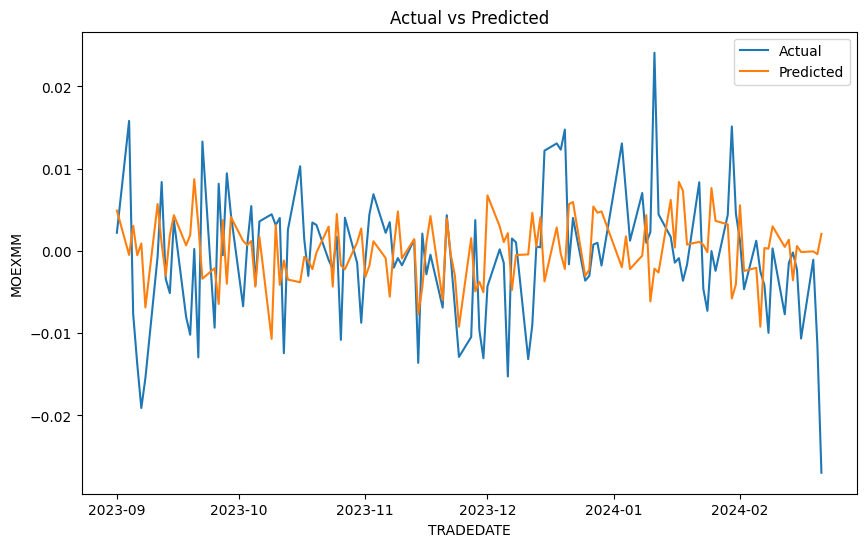

In [141]:
ts.get_visualisation(start_date='2023-09-01')